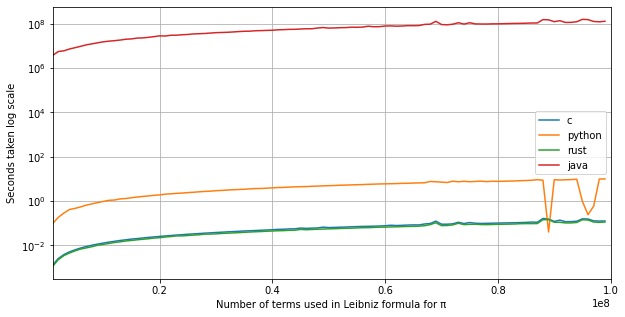

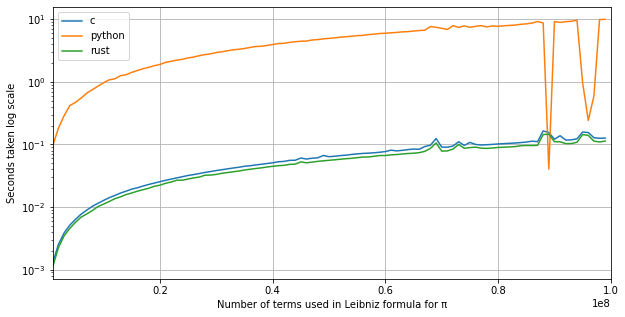

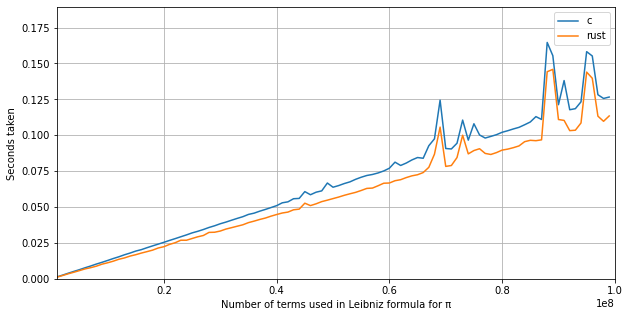

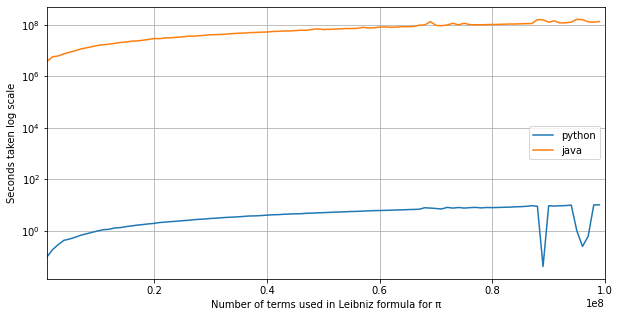

In [3]:
import pandas as pd
from multiprocessing import Process, Queue
import re
import subprocess

LOW = 1_000_000
HIGH = 100_000_000
CONFIG = {
    "C":{
        "build":["gcc","-O3","C_pi/src/main.c","-o","C_pi/build/pi_bench"],
        "bin": "./C_pi/build/pi_bench"
    },
    "Rust":{
        "build":["cargo", "build","--release", "--manifest-path=Rust_pi/Cargo.toml"],
        "bin":"./Rust_pi/target/release/pi_bench"
    },
    "Java":{
        "build":["javac", "Java_pi/src/Main.java", "-d", "Java_pi/build"],
        "bin": ["java", "-cp", "Java_pi/build", "Main"]
    },
    "Python": {
        "build":["python","Python_pi/main.py"],
        "bin":["python","Python_pi/main.py"]
    }
}

def bench_py(n,binary):
    args = binary+[str(n)]
    out_py = subprocess.check_output(args=args).decode("utf-8")
    py_time = float(re.search(pattern="([0-9].[0-9]*) seconds",string=out_py)[1])
    return py_time

def bench_rust(n,binary):
    out_rust = subprocess.check_output(args=[F"{binary}", str(n)]).decode("utf-8")
    rust_time = float(re.search(pattern="([0-9].[0-9]*) seconds",string=out_rust)[1])
    return rust_time

def bench_c(n,binary):
    out_c = subprocess.check_output(args=[F"{binary}", str(n)]).decode("utf-8")
    c_time = float(re.search(pattern="([0-9].[0-9]*) seconds",string=out_c)[1])
    return c_time

def bench_java(n,binary):
    args = binary+[str(n)]
    out_java = subprocess.check_output(args=args).decode("utf-8")
    java_time = float(re.search(pattern="([0-9].[0-9]*) seconds",string=out_java)[1])
    return java_time


def log_bench(min,max,skip):
    data = []
    
    for n in range(min,max,skip):
        py_time = bench_py(n, binary=CONFIG["Python"]["bin"])
        rust_time = bench_rust(n,binary=CONFIG["Rust"]["bin"])
        c_time = bench_c(n,binary=CONFIG["C"]["bin"])
        java_time = bench_java(n,binary=CONFIG["Java"]["bin"])
        
        diff_py_rs = py_time - rust_time
        ratio_py_rs = py_time / rust_time

        diff_py_c = py_time - c_time
        ratio_py_c = py_time / c_time

        diff_py_java = py_time - java_time
        ratio_py_java = py_time / java_time

        data.append([n, py_time, rust_time, c_time, java_time ,diff_py_rs, diff_py_c, diff_py_java, ratio_py_rs, ratio_py_c, ratio_py_java])
    
    return data

def compile_bins():
    for lang in CONFIG:
        build = CONFIG[lang]["build"]
        bin = CONFIG[lang]["bin"]
        out = subprocess.run(args=build,capture_output=True)
        if out.returncode==0:
            print(F"{lang} => success => {bin}")
        else:
            print(F"{out.stderr.decode('utf-8')}")

def run_analysis():
    header = ['terms', 'python', 'rust', 'c', 'java', 'py-rs', 'py-c', 'py-j', 'py/rs', 'py/c', 'py/j']
    data = log_bench(min=LOW,max=HIGH,skip=HIGH//100)
    df = pd.DataFrame(columns=header, data=data)
    plot_config ={
            "kind":'line',
            "x":'terms',
            "figsize":(10,5), 
            "grid":True, 
            "xlim":(LOW,HIGH),
            "xlabel":"Number of terms used in Leibniz formula for π",
    }

    df.plot(**plot_config,y=["c","python","rust","java"],logy=True, ylabel="Seconds taken log scale")
    
    df.plot(**plot_config,y=["c","python","rust"],logy=True, ylabel="Seconds taken log scale")

    max_cr = df[['c', 'rust']].max().max()
    df.plot(**plot_config,y=["c","rust"],ylim=(0,max_cr+(0.15*max_cr)), ylabel="Seconds taken")

    df.plot(**plot_config,y=["python","java"],logy=True, ylabel="Seconds taken log scale")
    

run_analysis()